In [1]:
import sys
home_path = "../"
yolov_home_path = "../yolov5/"
sys.path.insert(0, home_path)
sys.path.insert(0, yolov_home_path)

In [2]:
import cv2

In [3]:
import torch

In [4]:
from ocr_dfs.files_dfs_detector import FilesDFSDetector, get_image_from_box
from ocr_dfs.clean_image_pipeline import PipelineImg
from ocr_dfs.text_dfs_analyzer import TextDFSEvaluator
from ocr_dfs.files_dfs_detector import get_text

In [30]:
import torch
torch.set_num_threads(1) 

In [31]:
import numpy as np
import os
# Para correr en hilos la evaluación este parametro aumenta significativamente la velocidad de evaluacion
os.environ['OMP_THREAD_LIMIT'] = '1'

In [32]:
FilesDFSDetector.device

device(type='cpu')

In [8]:
text_evaluator = TextDFSEvaluator("../models/word_vectorizer.pckl", "../models/word_integrity.pckl")

In [9]:
detector = FilesDFSDetector("../models/files_dfs_detector/v1.0.pt", text_dfs_analyzer=text_evaluator)

Fusing layers... 


/home/datadog/anaconda3/envs/archivos_represion_kernel/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
import pytesseract
def get_text(img):
    
    config = ("-l spa --oem 1 --psm 6 ")
    text_data = None
    text_data = (pytesseract.image_to_string(img, config=config))
    return text_data

In [11]:
%matplotlib inline

In [48]:
def get_best_punctutated_transformation(imgs, names):
    ocr_imgs = [get_text(img) for img in imgs]
    ocr_puntcutations = text_evaluator.evaluate(ocr_imgs)[1]
    img_selected = int(np.argmax(ocr_puntcutations))
    return imgs[img_selected], ocr_imgs[img_selected], names[img_selected], ocr_imgs[0]

In [56]:
def get_best_lecture(img, boxes, debug=False):
    #print(boxes)
    images = [get_image_from_box(img,box["box"]) for box in boxes]
    pipelines = [PipelineImg.do_full_pipeline_yolov(sub_img, debug=debug, figsize=(15,15)) for sub_img in images]
    
    names=["original"]+["transformacion_{}".format(fl) for fl in range(len(pipelines[0][0]))]
    
    return [get_best_punctutated_transformation([images[indx]]+pipelines[indx][0], names=names) for indx in range(len(images))]
    get_image_from_box(image,box["box"])
def execute_all_steps(path, debug=False):
    try:
        img = cv2.imread(path)
        response = {"is_dfs_file":0,"is_dfs_file_prob":0.0,"angle":0,"boxes":None}
        result = detector.get_dfs_angle_attributes(img)
        print(".")
        if result is not None:
            is_dfs_file, is_dfs_file_prob, angle, img_rotated, boxes = result

            response["is_dfs_file"] = is_dfs_file
            response["is_dfs_file_prob"] = is_dfs_file_prob
            response["angle"] = angle
            response["boxes"] = boxes["boxes"]
            response["num_boxes"] = boxes["num_boxes"]
            response["lectures"] = []
            best_lectures = get_best_lecture(img_rotated, boxes["boxes"], debug=debug)
            for lec in best_lectures:
                response["lectures"].append({
                "best_lecture_text":lec[1],
                "name_transformation":lec[2],
                "normal_lecture_text":lec[3],
                })
        return [path, response ]
        print(".",end="", sep="")
    except:
        print("-",end="", sep="")
        return [path, None]

In [63]:
def print_only_one_img(image):
    plt.figure(num=None, figsize=(10, 10), facecolor='w', edgecolor='k')
    plt.title("Imagen original")
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [54]:
from matplotlib import pyplot as plt
def draw_boxes(image,boxes):
    
    plt.figure(num=None, figsize=(10, 10), facecolor='w', edgecolor='k')
    plt.title("Imagen original")
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    #print(get_text(image))
    for box in boxes["boxes"]:
        sub_img = get_image_from_box(image,box["box"])
        pre_pro,_,_ = PipelineImg.do_full_pipeline_yolov(sub_img, debug=True, figsize=(15,15))
        best_img, text, name, text_original= get_best_punctutated_transformation([sub_img]+pre_pro, names=["original"]+["transformacion_{}".format(fl) for fl in range(len(pre_pro))])
        print(name)
        print(text)
        print("Original")
        print(text_original)
        
        

# Ejemplo con una ficha

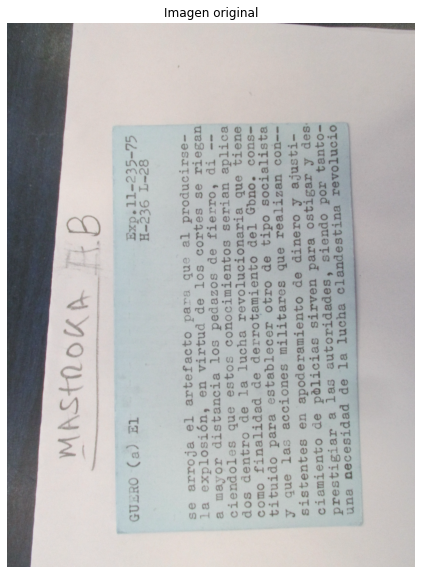

.


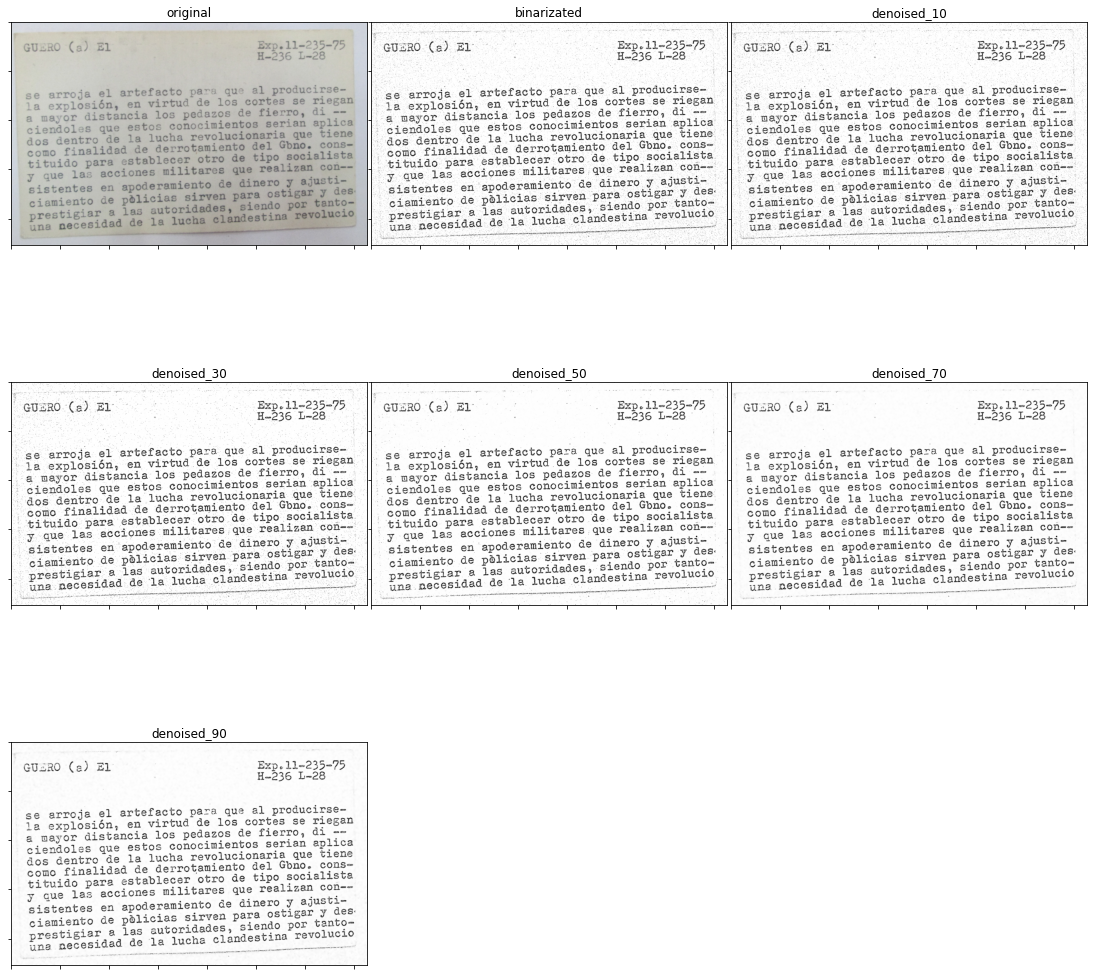

CPU times: user 1min 8s, sys: 1.92 s, total: 1min 10s
Wall time: 1min 30s


In [64]:
%%time
path="img/FicheroEjemplo.jpeg"
print_only_one_img(cv2.imread(path))
response = execute_all_steps(path, debug=True)

In [65]:
response[1]

{'is_dfs_file': 1,
 'is_dfs_file_prob': 0.9107218384742737,
 'angle': 90,
 'boxes': [{'conf': 0.890552818775177,
   'box': [322, 877, 3817, 3012],
   'type': 1,
   'class': 'fichero'}],
 'num_boxes': 1,
 'lectures': [{'best_lecture_text': 'GUZ¿RO (a) El | | EXp+11-235-75\nH-236 L-28\nse arroja el artefacto para que al producirse-\nla explosión, en virtud de los cortes se riegan\na mayor distancia los pedazos de fierro, di --\nciendoles que estos conocimientos serian aplica\ndos dentro de la lucha revolucionaria que tiene\ncomo finalidad de derrotamiento del Gbno. cons-\ntituido para establecer otro de tipo socialista\ny que las acciones militares que realizan con--\n—sistentes en apoderamiento de dinero y ajusti-\n“iamiento de púlicias sirven para ostigar y 0\nprestigiar a las autoridades, siendo por fons\n',
   'name_transformation': 'original',
   'normal_lecture_text': 'GUZ¿RO (a) El | | EXp+11-235-75\nH-236 L-28\nse arroja el artefacto para que al producirse-\nla explosión, en virt

<b> El mejor texto encontrado </b>

In [59]:
print(response[1]["lectures"][0]["best_lecture_text"])

GUZ¿RO (a) El | | EXp+11-235-75
H-236 L-28
se arroja el artefacto para que al producirse-
la explosión, en virtud de los cortes se riegan
a mayor distancia los pedazos de fierro, di --
ciendoles que estos conocimientos serian aplica
dos dentro de la lucha revolucionaria que tiene
como finalidad de derrotamiento del Gbno. cons-
tituido para establecer otro de tipo socialista
y que las acciones militares que realizan con--
—sistentes en apoderamiento de dinero y ajusti-
“iamiento de púlicias sirven para ostigar y 0
prestigiar a las autoridades, siendo por fons



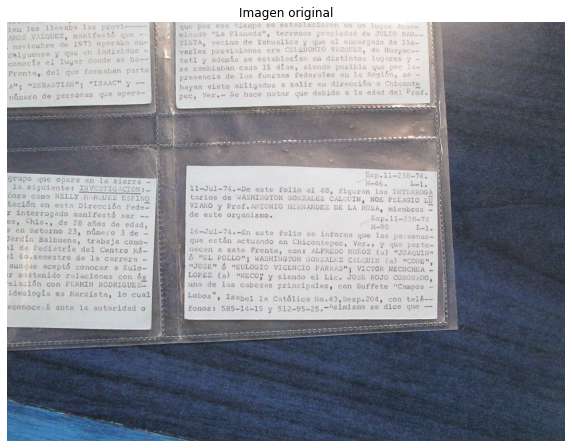

.


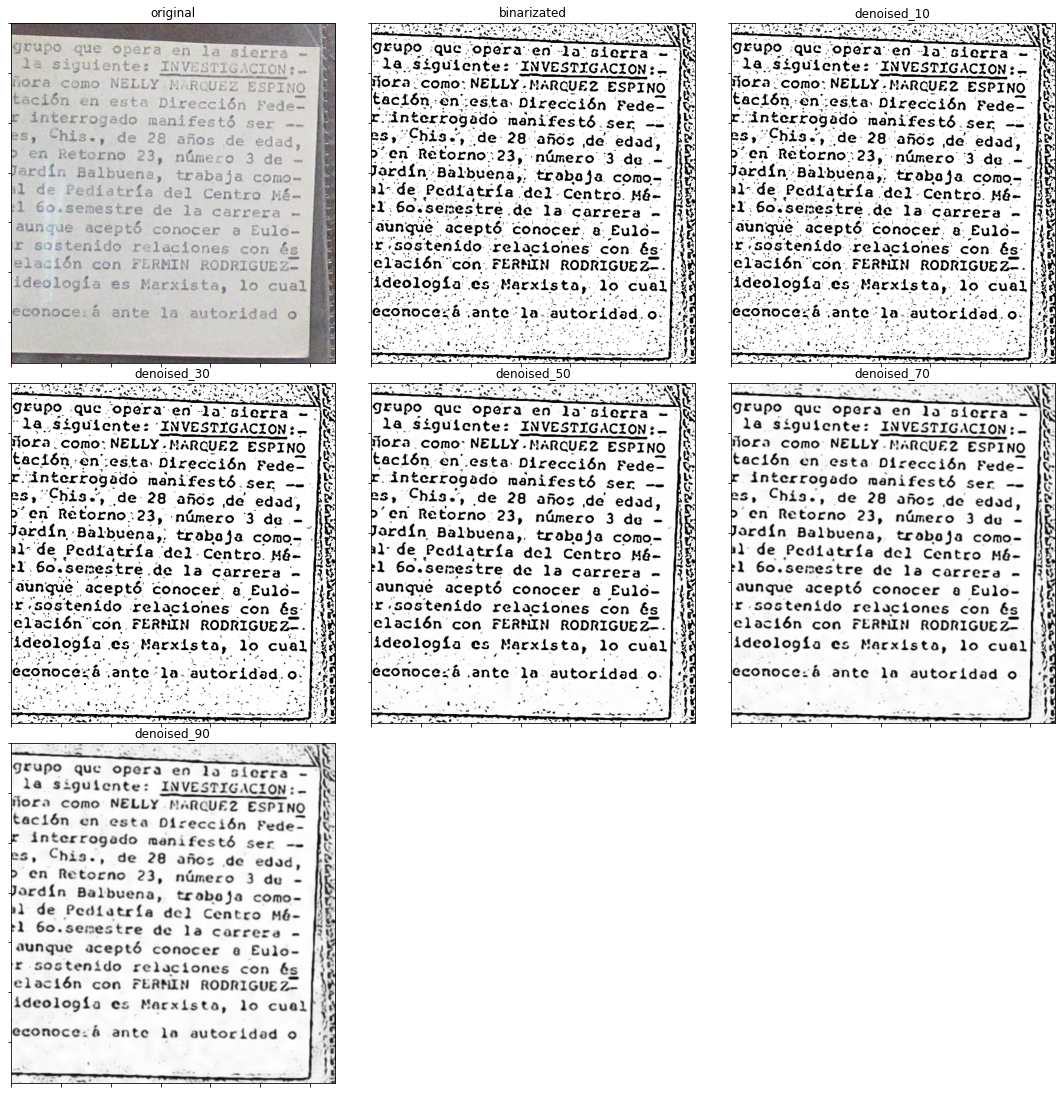

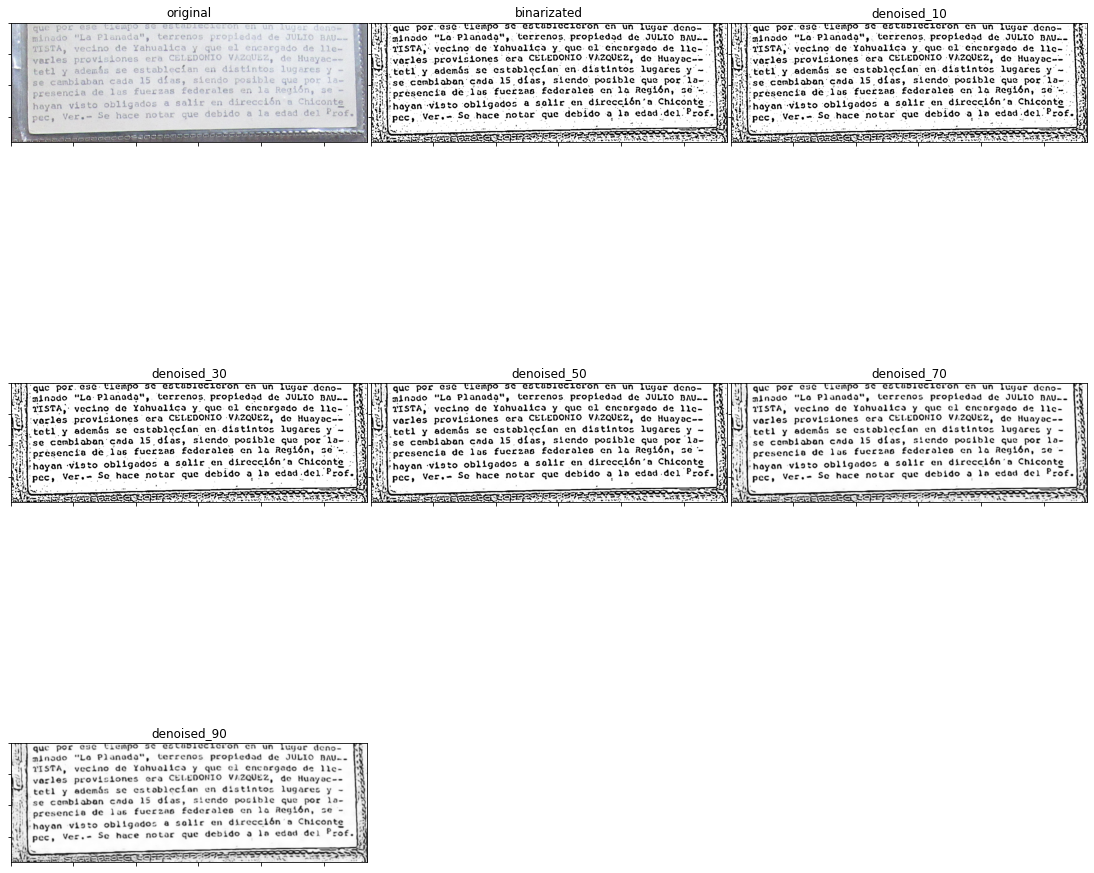

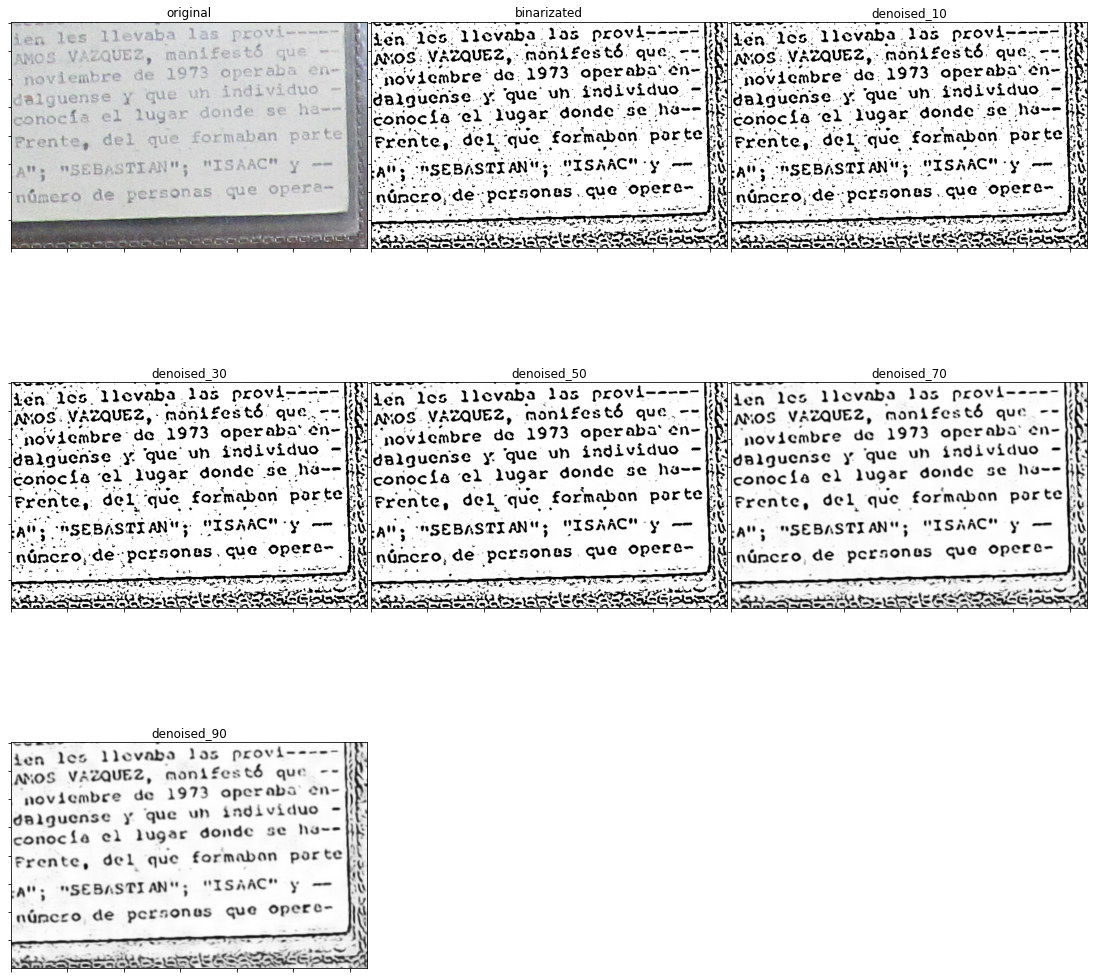

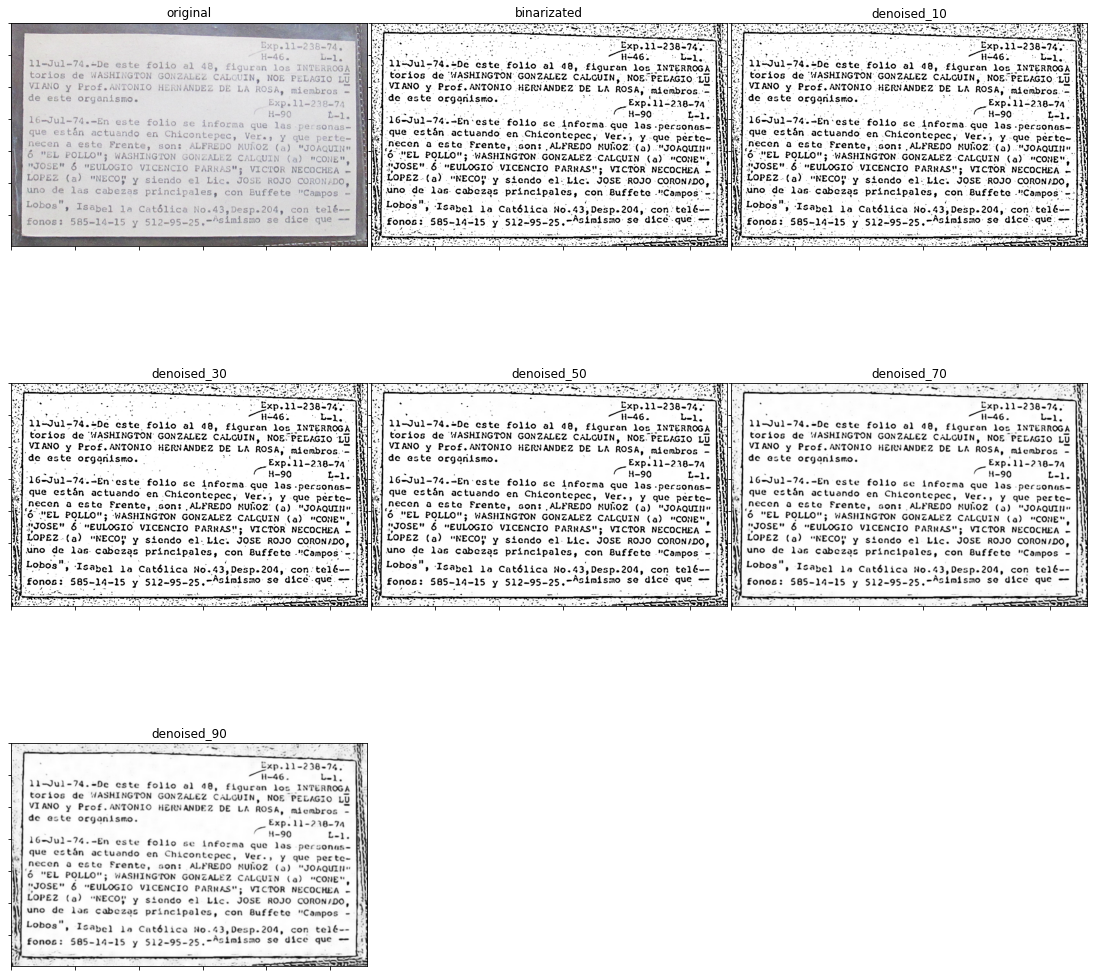

CPU times: user 20.7 s, sys: 2.53 s, total: 23.2 s
Wall time: 38.1 s


In [66]:
%%time
path="img/multiples_ficheros.jpeg"
print_only_one_img(cv2.imread(path))
response_2 = execute_all_steps(path, debug=True)


<b> El mejor texto encontrado </b>

In [61]:
for resp in response_2[1]["lectures"]:
    print("Mejor: {}".format(resp["name_transformation"]))
    print(resp["best_lecture_text"])

Mejor: original
grupo que opera en la sierra - W
la siguiente: INVESTIGACION+. H

ñora como NELLY MARQUEZ ESPINO |
tación en esta Dirección Fede- M
E interrogado manifestó ser -=- E
es, Chis., de 28 años de edad, Y
2 En Retorno 23, número 3 de -
Jardín Balbuena, trabaja como-= Y
31 de Pediatría del Centro mé- MA
21 6o0.semestre de la carrera - E
aunque aceptó conocer a Eulo- É
I sostenido relaciones con és le
elación con FERMIN RODRIGUEZ [MN
ideología es Marxista, lo cual E
E

econoce:á ante la autoridad o +

Mejor: transformacion_3
y|] que por eye Ciempo se estublecicron ca un luyar deno- ,
E minado "La Planada", terrenos propíedad de JULIO DAV.- k
y TISTA, vecino de Yohualica y que cl encargado de l1e- :
E vozles provisiones era CELEDONIO VAZQUEZ, de Huayoc-- q
| totl y edemás se establecían en distintos lugares y - |;
jiji] se combiaban cado 15 días, siendo posíble que por la- ps
"| presencia de las fuerzas federales cn la Región, ze - |¿
Y «hayan visto obligados a solir en direcció

# Ejecutando para todos los ficheros en paralelo

La celda de abajo es para evitar ejecutar por error

In [62]:
9234723saio

SyntaxError: invalid syntax (1052759919.py, line 1)

In [15]:
import pandas as pd
segunda_dataframe = pd.read_pickle("../../../gitlab/archivos_represion_ml/text/ficheros_ocr_data.pkcl")

In [16]:

disk_prx = "/media/juan/jc/archivos_represion/"
segunda_dataframe["path"] = segunda_dataframe["path"].apply(lambda el: el.replace(disk_prx, "/media/datadog/second_ssd/Ubuntu/archivos_represion/"))

In [33]:
def a(b):
    return b*3

In [34]:
%%time
import multiprocessing as mp
print("Procesando con {} nucleos".format(mp.cpu_count()))
pool = mp.Pool(mp.cpu_count())
results = pool.map(a, [2,3,4])
pool.close()

Procesando con 24 nucleos
CPU times: user 10.1 ms, sys: 387 ms, total: 397 ms
Wall time: 670 ms


In [ ]:
results

In [36]:
import pandas as pd

In [38]:
%%time
import multiprocessing as mp
print("Procesando con {} nucleos".format(mp.cpu_count()))
pool = mp.Pool(mp.cpu_count())
results = pool.map(execute_all_steps, segunda_dataframe["path"].head(24).to_numpy())
pool.close()
ocr_result_zero = pd.DataFrame(results, columns=["path", "metadata"])
ocr_result_zero.to_pickle("ejecuciones//full_pipeline.pkcl")

Procesando con 24 nucleos
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
CPU times: user 192 ms, sys: 523 ms, total: 715 ms
Wall time: 4min 41s
